In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.special import hyp2f1, ellipeinc
from scipy.special import comb

import sys
sys.path.append("..")

import utils

In [2]:
def G(n, f):

    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - (y / (1 - f)) ** 2)))

    if nu % 2 == 0:

        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu + 2)) * (y / (1 - f)) ** (0.5 * nu),
        ]

    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):

        G = [lambda x, y: (1 - f) * x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]

    elif (mu == 1) and (l % 2 != 0):

        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]

    else:

        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * (y / (1 - f)) ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]

    return G


def primitive(x, y, dx, dy, theta1, theta2, f, rot, n=0):
    def func(theta):
        Gx, Gy = G(n, f)
        xr = lambda theta: x(theta) * np.cos(rot) + y(theta) * np.sin(rot)
        yr = lambda theta: -x(theta) * np.sin(rot) + y(theta) * np.cos(rot)
        dxr = lambda theta: dx(theta) * np.cos(rot) + dy(theta) * np.sin(rot)
        dyr = lambda theta: -dx(theta) * np.sin(rot) + dy(theta) * np.cos(rot)
        return Gx(xr(theta), yr(theta)) * dxr(theta) + Gy(xr(theta), yr(theta)) * dyr(
            theta
        )

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def pT_numerical(lmax, phi, b, r, f, theta):
    pT = np.zeros((lmax + 1) ** 2)
    for n in range((lmax + 1) ** 2):
        for phi1, phi2 in np.reshape(phi, (-1, 2)):
            x = lambda phi: r * np.cos(phi)
            y = lambda phi: (b + r * np.sin(phi))
            dx = lambda phi: -r * np.sin(phi)
            dy = lambda phi: r * np.cos(phi)
            pT[n] += primitive(x, y, dx, dy, phi1, phi2, f, theta, n)
    return pT.reshape(1, -1)


def tT_numerical(lmax, xi, b, r, f, theta):
    tT = np.zeros((lmax + 1) ** 2)
    for n in range((lmax + 1) ** 2):
        for xi1, xi2 in np.reshape(xi, (-1, 2)):
            x = lambda xi: np.cos(theta) * np.cos(xi) - (1 - f) * np.sin(
                theta
            ) * np.sin(xi)
            y = lambda xi: np.sin(theta) * np.cos(xi) + (1 - f) * np.cos(
                theta
            ) * np.sin(xi)
            dx = lambda xi: -np.cos(theta) * np.sin(xi) - (1 - f) * np.sin(
                theta
            ) * np.cos(xi)
            dy = lambda xi: -np.sin(theta) * np.sin(xi) + (1 - f) * np.cos(
                theta
            ) * np.cos(xi)
            tT[n] += primitive(x, y, dx, dy, xi1, xi2, f, theta, n)
    return tT.reshape(1, -1)


def sT_numerical(lmax, phi, xi, b, r, f, theta):
    return pT_numerical(lmax, phi, b, r, f, theta) + tT_numerical(
        lmax, xi, b, r, f, theta
    )

In [3]:
def integrate(f, a, b, epsabs=1e-12, epsrel=1e-12, **kwargs):
    return quad(f, a, b, epsabs=epsabs, epsrel=epsrel, **kwargs)[0]

In [4]:
class Solver:
    def __init__(self, lmax):

        # Pre-compute case conditions
        self.lmax = lmax
        self.cases = np.zeros((self.lmax + 1) ** 2, dtype=int)
        self.l = np.zeros((self.lmax + 1) ** 2, dtype=int)
        self.m = np.zeros((self.lmax + 1) ** 2, dtype=int)
        for n in range((self.lmax + 1) ** 2):
            self.cases[n] = self.get_case(n)
            self.l[n] = int(np.floor(np.sqrt(n)))
            self.m[n] = n - self.l[n] ** 2 - self.l[n]

    def get_case(self, n):
        l = int(np.floor(np.sqrt(n)))
        m = n - l ** 2 - l
        mu = l - m
        nu = l + m
        if (nu % 2) == 0:
            return 1
        elif (l == 1) and (m == 0):
            return 2
        elif ((nu % 2) == 1) and (mu == 1) and ((l % 2) == 0):
            return 3
        elif ((nu % 2) == 1) and (mu == 1) and ((l % 2) == 1):
            return 4
        else:
            return 5

    def solve(self, f0, fN, A, B, C, N):
        """
        Solve a recursion relation of the form
        
            f(j) = A(j) * f(j - 1) + B(j) * f (j - 2) + C(j)
        
        given a lower boundary condition f(0) and 
        an upper boundary condition f(N).
        
        """
        # Set up the tridiagonal problem
        a = np.empty(N - 1)
        b = np.empty(N - 1)
        c = np.empty(N - 1)
        for i, j in enumerate(range(2, N + 1)):
            a[i] = -A(j)
            b[i] = -B(j)
            c[i] = C(j)

        # Add the boundary conditions
        c[0] -= b[0] * f0
        c[-1] -= fN

        # Construct the tridiagonal matrix
        A = np.diag(a, 0) + np.diag(b[1:], -1) + np.diag(np.ones(N - 2), 1)

        # Solve using a dense solver for stability
        soln = np.linalg.solve(A, c)
        return np.concatenate(([f0], soln, [fN]))

    def get_W(self, k2, phi1, phi2):
        """
        Return the vector of `W` integrals, computed
        recursively given a lower boundary condition
        (analytic in terms of elliptic integrals) and an upper
        boundary condition (computed numerically).

        The term `W_j` is the solution to the integral of
        
            sin(u)^(2 * j) * sqrt(1 - sin(u)^2 / (1 - k^2))

        from u = u1 to u = u2, where 
        
            u = (pi - 2 * phi) / 4

        """
        # Useful quantities
        kc2 = 1 - k2
        u1 = 0.25 * (np.pi - 2 * phi1)
        u2 = 0.25 * (np.pi - 2 * phi2)
        u = np.array([u1, u2])
        sinu = np.sin(u)
        cosu = np.cos(u)
        diff = lambda x: np.diff(x)[0]
        D = (1 - sinu ** 2 / kc2) ** 0.5

        # The two boundary conditions
        # TODO: How should we evaluate fN?
        N = 2 * self.lmax + 4
        f0 = diff(ellipeinc(u, 1 / kc2))
        fN = quad(
            lambda u: np.sin(u) ** (2 * N) * (1 - np.sin(u) ** 2 / kc2) ** 0.5,
            u1,
            u2,
            epsabs=1e-12,
            epsrel=1e-12,
        )[0]

        # The recursion coefficients
        A = lambda j: 2 * (j + (j - 1) * kc2) / (2 * j + 1)
        B = lambda j: -(2 * j - 3) / (2 * j + 1) * kc2
        C = lambda j: diff(kc2 * sinu ** (2 * j - 3) * cosu * D ** 3) / (2 * j + 1)

        # Solve the linear system
        return self.solve(f0, fN, A, B, C, N)

    def get_V(self, k2, phi1, phi2):
        """
        Return the vector of `V` integrals, computed
        recursively given a lower boundary condition
        (trivial) and an upper boundary condition 
        (computed from `2F1`). 
        
        The term `V_i` is the solution to the integral of
        
            cos(phi) sin(phi)^i sqrt(1 - w^2 sin(phi))
        
        from phi=phi1 to phi=phi2.
        
        """
        N = 2 * self.lmax + 4
        invw2 = 2 * k2 - 1

        V = np.zeros((N + 1, 2))
        for i, phi in enumerate([phi1, phi2]):

            # Useful quantities
            sinphi = np.sin(phi)
            x = sinphi / invw2

            # The two boundary conditions
            f0 = (2.0 / 3.0) * (1 - (1 - x) ** 1.5) * invw2
            fN = sinphi ** (N + 1) / (N + 1) * hyp2f1(-0.5, N + 1, N + 2, x)

            # The recursion coefficients
            A = lambda j: (2 * j + (2 * j + 1) * x) * invw2 / (2 * j + 3)
            B = lambda j: -2 * (j - 1) * sinphi * invw2 / (2 * j + 3)
            C = lambda j: 0.0

            # Solve the linear system
            V[:, i] = self.solve(f0, fN, A, B, C, N)

        return np.diff(V, axis=1)

    def get_J(self, k2, phi1, phi2):
        """
        Return the `J` matrix of integrals. The term `J_{p,q}`
        is equal to the integral of
        
            cos(phi)^p sin(phi)^q sqrt(1 - w^2 sin(phi))
            
        from phi=phi1 to phi=phi2.
        
        """
        W = self.get_W(k2, phi1, phi2)
        V = self.get_V(k2, phi1, phi2)
        w2 = 1 / (2 * k2 - 1)
        c1 = -2.0 * (1 - w2) ** 0.5

        J = np.zeros((self.lmax + 3, self.lmax + 3))
        for s in range((self.lmax + 3) // 2):
            for q in range(self.lmax + 3):
                fac = 1
                for i in range(s + 1):
                    term = 0
                    amp = 1
                    for j in range(2 * i + q + 1):
                        term += amp * W[j]
                        amp *= -2 * (2 * i + q - j) / (j + 1)
                    J[2 * s, q] += c1 * fac * term
                    J[2 * s + 1, q] += fac * V[2 * i + q]
                    fac *= (i - s) / (i + 1)
        return J

    def get_L(self, phip1, phip2):
        """
        Return the `L` matrix of integrals. The term `L_{i, j}`
        is equal to the integral of
        
            cos(phi)^i sin(phi)^j
            
        from phi=phip1 to phi=phip2, where
        
            phip = phi - theta
            
        (pT integral) or
        
            phip = xi
            
        (tT integral).
        
        """
        # Lower boundary
        L = np.zeros((self.lmax + 3, self.lmax + 3))
        L[0, 0] = phip2 - phip1
        L[1, 0] = np.sin(phip2) - np.sin(phip1)
        L[0, 1] = np.cos(phip1) - np.cos(phip2)
        L[1, 1] = 0.5 * (np.cos(phip1) ** 2 - np.cos(phip2) ** 2)

        # Recursion coeffs
        cp1 = np.cos(phip1)
        cp2 = np.cos(phip2)
        sp1 = np.sin(phip1)
        sp2 = np.sin(phip2)
        A0 = cp1 * sp1
        B0 = cp2 * sp2
        C0 = cp2 * sp2
        D0 = cp1 * sp1

        # Recurse
        for u in range(self.lmax + 3):
            A = A0
            B = B0
            C = C0
            D = D0
            for v in range(2, self.lmax + 3):
                fac = 1.0 / (u + v)
                L[u, v] = fac * (A - B + (v - 1) * L[u, v - 2])
                L[v, u] = fac * (C - D + (v - 1) * L[v - 2, u])
                A *= sp1
                B *= sp2
                C *= cp2
                D *= cp1
            A0 *= cp1
            B0 *= cp2
            C0 *= sp2
            D0 *= sp1

        return L

    def get_pT2(self, r, theta, f, b, phi1, phi2):
        """
        Return the `pT[2]` integral, computed by numerical integration.
        
        """
        bc = b * np.cos(theta)
        bs = b * np.sin(theta)
        p = (1 - f) ** (-2)

        def func(phi):
            z = np.sqrt(
                1
                - (r * np.cos(phi - theta) + bs) ** 2
                - p * (r * np.sin(phi - theta) + bc) ** 2
            )
            z = max(1e-12, min(z, 1 - 1e-8))
            return r * (r + b * np.sin(phi)) * (1 - z ** 3) / (3 * (1 - z ** 2))

        res, _ = quad(func, phi1, phi2, epsabs=1e-12, epsrel=1e-12)
        return res

    def get_sT(self, b, r, f, theta, phi1, phi2, xi1, xi2):
        """
        Return the `sT` solution vector.
        
        TODO: Instabilities occur when
        
            - np.abs(costheta) < 1e-15
            - np.abs(sintheta) < 1e-15
            - np.abs(b) < 1e-3
            - r < 1e-3
            - np.abs(1 - b - r) < 1e-3
        
        """
        # Useful variables
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        tantheta = sintheta / costheta
        invtantheta = 1.0 / tantheta
        gamma = 1 - b ** 2 - r ** 2
        sqrtgamma = np.sqrt(gamma)
        w2 = 2 * b * r / gamma
        k2 = (gamma + 2 * b * r) / (4 * b * r)

        # Compute the S, C matrices
        S = np.zeros((self.lmax + 3, self.lmax + 3))
        C = np.zeros((self.lmax + 3, self.lmax + 3))
        fac0 = 1
        for i in range(self.lmax + 3):
            facs = r * fac0
            facc = fac0
            for j in range(i + 1):
                S[i, self.lmax + 2 + j - i] = facs
                C[self.lmax + 2 + j - i, i] = facc
                fac = b * (i - j) / (r * (j + 1))
                facs *= fac * sintheta
                facc *= fac * costheta
            fac0 *= r

        # Compute the B matrices
        A = np.empty((self.lmax + 3, self.lmax + 3))
        B = np.empty((self.lmax + 3, self.lmax + 3))
        fac0l = 1
        fac0r = 1
        for i in range(self.lmax + 3):
            facl = fac0l
            facr = fac0r
            for j in range(self.lmax + 3):
                A[i, j] = facl
                B[i, j] = facr
                fac = (i - j) / (j + 1)
                facl *= fac * tantheta
                facr *= -fac * invtantheta
            fac0l *= costheta
            fac0r *= -sintheta

        # Compute the first f derivative matrix
        D = -3 * np.array(
            [
                [
                    0.5 * (b ** 2 + r ** 2 + (b + r) * (b - r) * np.cos(2 * theta)),
                    2 * b * r * costheta ** 2,
                    r ** 2 * np.cos(2 * theta),
                ],
                [
                    -2 * b * r * costheta * sintheta,
                    -2 * r ** 2 * costheta * sintheta,
                    0,
                ],
            ]
        )

        # Compute the L and M integrals
        L = self.get_L(phi1 - theta, phi2 - theta)
        Lxi = (1 - f) * self.get_L(xi1, xi2)
        M = S[:-1, 1:] @ L[::-1, ::-1][:-1, :] @ C[:, :-1]

        # Compute the J integrals
        J = self.get_J(k2, phi1, phi2)
        J32 = gamma * sqrtgamma * (J[:-1, :-1] - w2 * J[:-1, 1:])
        J12 = sqrtgamma * J[:-1, :-1]

        # Compute the I integral
        I = np.zeros((self.lmax + 2, self.lmax + 2))
        T = np.zeros((self.lmax + 1, self.lmax))
        for i in range(self.lmax + 1):
            for j in range(min(self.lmax, i + 1)):

                # Taylor series in `f`
                J0 = J32[i - j, j]
                J1 = np.sum(D * (J12[i - j :, j:])[:2, :3])
                T[i, j] = J0 + f * J1

                for k in range(i + 1):
                    imk = i - k
                    for l in range(max(0, j - imk), min(k, j) + 1):
                        I[self.lmax + 1 - imk, self.lmax + 1 - k] += (
                            A[imk, j - l] * T[i, j] * B[k, l]
                        )

        # Compute the K, H integrals
        K = S[:-1, 2:] @ I[:-1, :] @ C[1:, :-1]
        H = S[:-1, 1:] @ I[:, :-1] @ C[2:, :-1]

        # Compute sT on a case-by-case basis
        sT = np.zeros((self.lmax + 1) ** 2)
        for n in range((self.lmax + 1) ** 2):
            l = self.l[n]
            m = self.m[n]
            mu = l - m
            nu = l + m
            if self.cases[n] == 1:
                pT = (1 - f) ** (-nu // 2) * M[(mu + 2) // 2, nu // 2]
                tT = Lxi[mu // 2 + 2, nu // 2]
                sT[n] = pT + tT
            elif self.cases[n] == 2:
                pT = self.get_pT2(r, theta, f, b, phi1, phi2)
                tT = (1 - f) * (xi2 - xi1) / 3
                sT[n] = pT + tT
            elif self.cases[n] == 3:
                sT[n] = -(1 - f) * H[l - 2, 0]
            elif self.cases[n] == 4:
                sT[n] = -H[l - 3, 1]
            else:
                sT[n] = (1 - f) ** ((1 - nu) // 2) * K[(mu - 3) // 2, (nu - 1) // 2]

        return sT.reshape(1, -1)


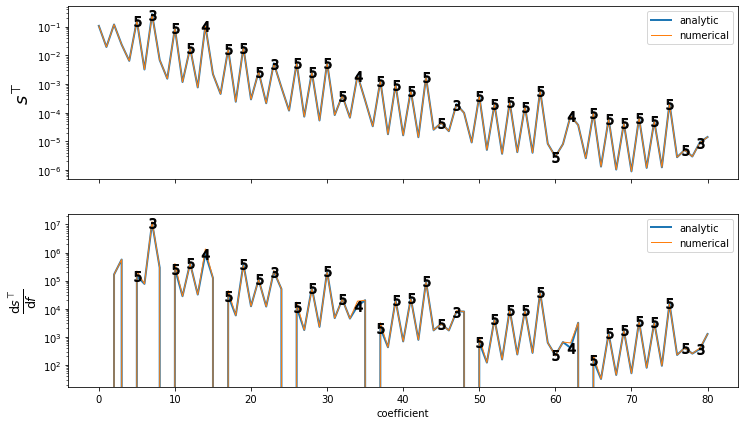

In [5]:
# Settings
lmax = 8
r = 0.25
theta = 0.4
b = 0.1
phi1 =  0
phi2 = np.pi
xi1 = 0
xi2 = 0
tol = 1e-12
df = 1e-8
dtol = 1e-5
solver = Solver(lmax)

# Compute for f = 0
sT = solver.get_sT(b, r, 0.24, theta, phi1, phi2, xi1, xi2).reshape(-1)
sTnum = sT_numerical(lmax, [phi1, phi2], [xi1, xi2], b, r, 0.24, theta).reshape(-1)

# Compute for f = 0 + df to get the deriv
sT_df = solver.get_sT(b, r, df, theta, phi1, phi2, xi1, xi2).reshape(-1)
dsTdf = (sT_df - sT) / df
sTnum_df = sT_numerical(lmax, [phi1, phi2], [xi1, xi2], b, r, df, theta).reshape(-1)
dsTnumdf = (sTnum_df - sTnum) / df

# Compare
fig, ax = plt.subplots(2,1, figsize=(12, 7), sharex=True)
ax[0].plot(np.abs(sT), lw=2, label="analytic")
ax[0].plot(np.abs(sTnum), lw=1, label="numerical")
bad = np.array(np.abs(sTnum))
bad[np.abs(sT - sTnum) / np.abs(sT) < tol] = np.nan
for n in range((lmax + 1) ** 2):
    ax[0].plot(n, bad[n], color="k", marker=r"${:.0f}$".format(solver.get_case(n)), ms=10)
ax[0].legend(loc="upper right", fontsize=10)
ax[0].set_ylabel(r"$s^\top$", fontsize=18)
ax[0].set_yscale("log")

ax[1].plot(np.abs(dsTdf), lw=2, label="analytic")
ax[1].plot(np.abs(dsTnumdf), lw=1, label="numerical")
bad = np.array(np.abs(dsTdf))
bad[(np.abs(dsTdf) < tol) | (np.abs(dsTdf - dsTnumdf) / (np.abs(dsTdf) + tol) < dtol)] = np.nan
for n in range((lmax + 1) ** 2):
    ax[1].plot(n, bad[n], color="k", marker=r"${:.0f}$".format(solver.get_case(n)), ms=10)
ax[1].legend(loc="upper right", fontsize=10)
ax[1].set_ylabel(r"$\frac{\mathrm{d}s^\top}{\mathrm{d}f}$", fontsize=18)
ax[1].set_yscale("log")
ax[1].set_xlabel("coefficient");

In [6]:
sT

array([ 1.05757103e-01,  1.94956587e-02,  1.18206592e-01,  2.35267148e-02,
        6.40989955e-03,  1.61555086e-01,  3.19683904e-03, -2.71035455e-01,
        6.84645383e-03,  1.53278732e-03,  8.79156850e-02,  1.16626586e-03,
        1.81024917e-02,  7.57484035e-04, -1.08782338e-01,  2.20979995e-03,
        4.51242639e-04,  1.63223864e-02,  2.41363662e-04,  1.90935733e-02,
        2.90746001e-04,  2.66763069e-03,  2.13559867e-04, -5.25209448e-03,
        7.56688475e-04,  1.18481139e-04,  5.39014921e-03,  7.28808301e-05,
        2.58262448e-03,  5.35419786e-05,  5.48787417e-03,  8.28449182e-05,
        3.95265856e-04,  6.71207604e-05, -2.00885457e-03,  2.69632537e-04,
        3.37209630e-05,  1.29335694e-03,  1.77821403e-05,  9.57493104e-04,
        1.62749829e-05,  5.97201603e-04,  1.39571042e-05,  1.75618615e-03,
        2.55498991e-05,  4.43256620e-05,  2.26870615e-05, -1.97295176e-04,
        9.89486752e-05,  9.19683712e-06,  3.81762968e-04,  5.05747953e-06,
        1.98205922e-04,  

In [7]:
%timeit solver.get_sT(b, r, 0.0, theta, phi1, phi2, xi1, xi2)

5.17 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit sT_numerical(lmax, [phi1, phi2], [xi1, xi2], b, r, 0.0, theta).reshape(-1)

248 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
